# Effect of "treatment class" on analysis

Can we capture the true ATE using estimated labels? Let's do a simulation! Let's try to keep things simple:

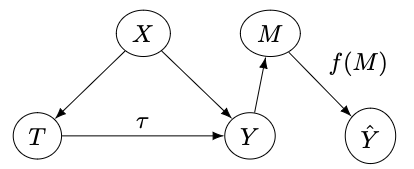

- $X$ is some confounder (e.g. urban/rural where urban areas are wealthier *and* more likely to be treated)
- $T$ is the treatment with a treatment effect $\tau$, (e.g. World Bank intervention)
- $Y$ is the outcome (change in IWI)

In our setting, we usually can't observe IWI directly. Instead, we have to rely on proxy values obtained from EO-ML.

- $M$ is the data we can observe, i.e. the satellite image. In reality, this is most likely influenced by both $X$ and $T$, but we keep it simple.
- $\hat{Y}$ is the estimate of $Y$ that we get by passing our image through the EO-ML model, $f(M)$.

In [1]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

For this to work, there must be some function `m_func(Y)` that generates an "image embedding" $M$ from a wealth level $Y$. Here, we say that this is a simple first degree polynomial, such that:

$$
M = \begin{bmatrix}
           2Y \\
           3Y \\
           -4Y
         \end{bmatrix} + \epsilon
$$

In [2]:
# Define a simple first-order function to generate M from Y
m_func = lambda Y: np.vstack([2 * Y, 3 * Y, -4 * Y]).T

I generate some samples in accordance with the DAG and `m_func` above. 

In [3]:
def generate_population(n_samples=10000, alpha=1.0, sigma_Y=1.0, m_func=None, sigma_M=0.5, seed=42, n_components=1):
    """
    n_samples: Number of samples
    alpha: Effect of confounder X on Y
    sigma_Y: Noise in Y
    m_func: Function to generate M from Y
    sigma_M: Noise in M (proxy for Y)
    n_components: Number of components in M
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Generate confounder X ~ N(0, 1)
    X = np.random.normal(0, 1, n_samples)

    # Generate outcome Y ~ N(alpha * X, sigma_Y)
    Y = alpha * X + np.random.normal(0, sigma_Y, n_samples)

    # Generate proxy M = m_func(Y) + noise
    M = m_func(Y) + np.random.normal(0, sigma_M, (n_samples, n_components))

    population = pd.DataFrame({
        'X': X,
        'Y': Y,
        'M': list(M)
    })

    return population

tau = 2.0
n_components = 3
population = generate_population(m_func=m_func, n_components=n_components)

I now add two treatments, both with the effect $\tau=2.0$. The first effects the "image embedding" $M$ as defined in `m_func`, i.e.

$$
M_{t_1} = M + \begin{bmatrix}
           2\tau \\
           3\tau \\
           -4\tau
         \end{bmatrix}
$$

The second experiment, scales the embedding by a constant $w$. In this case, $w=1.1$ if $T=1$, else $w=1.0$:

$$
M_{t_2} = wM
$$

In [4]:
def add_treatment(row):
    seed = row.name
    np.random.seed(seed)
    
    # Generate treatment T ~ Bernoulli(p(X)) where p(X) is a logistic function of X
    p_T_given_X = 1 / (1 + np.exp(-row['X']))  # Logistic function
    T = np.random.binomial(1, p_T_given_X)
    
    row['p_T_given_X'] = p_T_given_X
    row['T'] = T
    
    # If in control, don't do anything
    if not T:
        row['Mt1'] = row['M']
        row['Mt2'] = row['M']
        return row
    
    tau = np.random.normal(2.0, 0.5)
    row['Y'] += tau
    
    # Change image embeddings with treatments
    M = row['M']
    Mt1 = M + m_func(tau).reshape(1, -1)
    row['Mt1'] = list(Mt1)
    
    w = 1.1
    Mt2 = tau * M
    row['Mt2'] = list(Mt2)
    
    return row

population = population.apply(add_treatment, axis=1)

We can now train two functions

In [13]:
# Objective function (squared residuals)
def objective(beta, X, y):
    residuals = X @ beta - y
    return np.sum(residuals**2)

# Constraint: y^T(Xβ - y) = 0
def constraint(beta, X, y):
    residuals = X @ beta - y
    return y.T @ residuals

def fit_model(population, n_components, M_col='M', verbose=1):
    M = np.vstack(population[M_col].values)
    Y = population['Y'].values
    
    # Initial guess for beta
    beta0 = np.zeros(n_components)

    # Define the constraint as a dictionary for `scipy.optimize.minimize`
    constr = {'type': 'eq', 'fun': constraint, 'args': (M, Y)}

    # Solve the constrained optimization problem
    result = minimize(objective, beta0, args=(M, Y), constraints=constr)

    # Extract the solution
    beta_solution = result.x
    if verbose > 0:
        print(result.message)
        print(beta_solution)
    
    # Predicted values
    pred_Y = M @ beta_solution

    res = Y - pred_Y
    population['Y_hat'] = pred_Y
    population['Residuals'] = res
    
    return population

population_t1 = fit_model(population.copy(), n_components, M_col='Mt1')
population_t2 = fit_model(population.copy(), n_components, M_col='Mt2')

Optimization terminated successfully
[ 0.06789662  0.10453215 -0.13754829]
Optimization terminated successfully
[-0.00608187  0.12243429 -0.22619261]


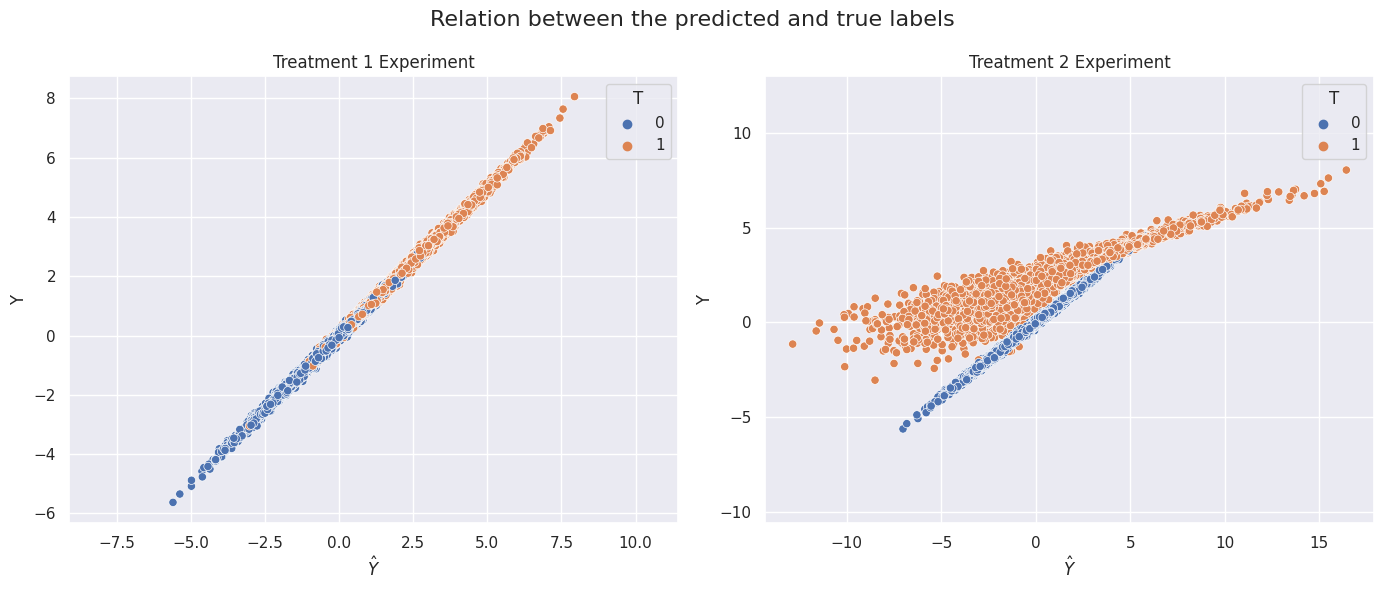

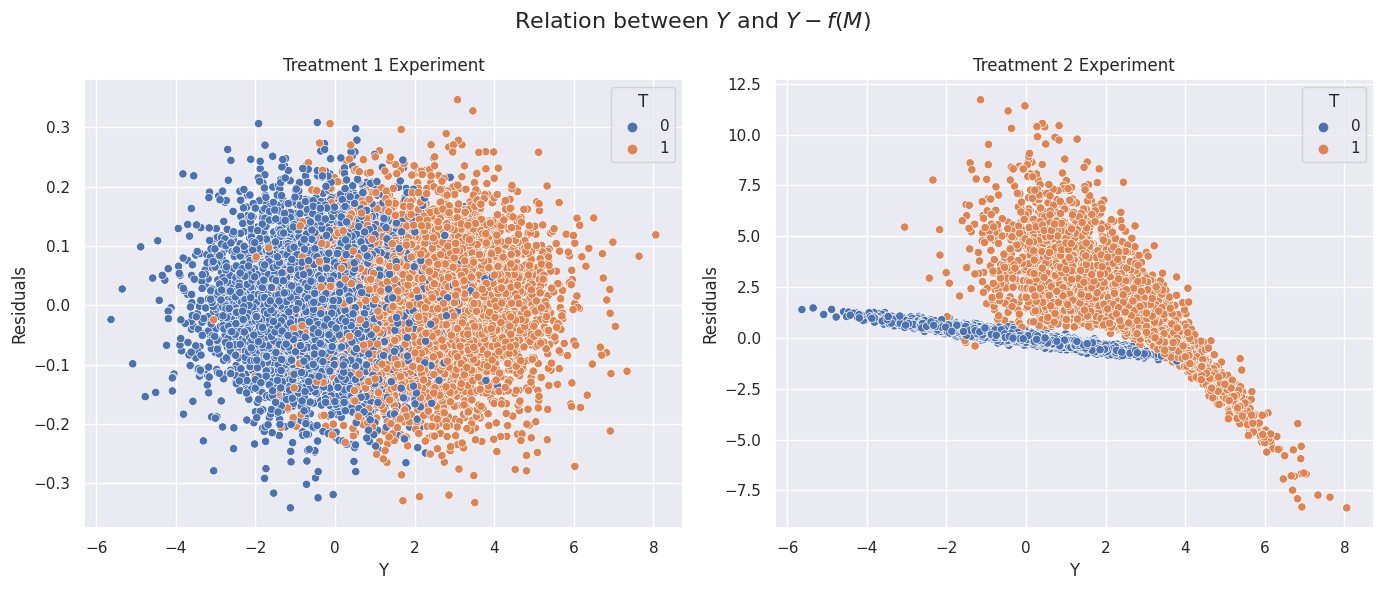

Experiment 1: Mean Residual for Treated: 0.001, Mean Residual for Control: 0.001
Experiment 2: Mean Residual for Treated: 0.103, Mean Residual for Control: 1.338


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=population_t1, x='Y_hat', y='Y', hue='T', ax=axes[0])
axes[0].set_title('Treatment 1 Experiment')
axes[0].set_xlabel(r'$\hat{Y}$')
axes[0].axis('equal')

sns.scatterplot(data=population_t2, x='Y_hat', y='Y', hue='T', ax=axes[1])
axes[1].set_title('Treatment 2 Experiment')
axes[1].set_xlabel(r'$\hat{Y}$')
axes[1].axis('equal')

fig.suptitle('Relation between the predicted and true labels', fontsize=16)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=population_t1, x='Y', y='Residuals', hue='T', ax=axes[0])
axes[0].set_title('Treatment 1 Experiment')

sns.scatterplot(data=population_t2, x='Y', y='Residuals', hue='T', ax=axes[1])
axes[1].set_title('Treatment 2 Experiment')

fig.suptitle(r'Relation between $Y$ and $Y-f(M)$', fontsize=16)

plt.tight_layout()
plt.show()

mean_res_t = population_t1.groupby('T')['Residuals'].mean()
print(f'Experiment 1: Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')
mean_res_t = population_t2.groupby('T')['Residuals'].mean()
print(f'Experiment 2: Mean Residual for Treated: {mean_res_t[0]:.3f}, Mean Residual for Control: {mean_res_t[1]:.3f}')

In [ ]:
#sns.scatterplot(data=population_with_rct, x=population_with_rct['M'].apply(lambda x: x[0]), y='Residuals', hue='T')
#plt.title(r'Relation between $M_0$ and $Y-f(M)$')
#plt.show()

In [14]:
def get_ate(population, pred_Y_col='Y_hat'):
    # Calculate IPTW weights
    weights_treated = population['T'].values / population['p_T_given_X'].values
    weights_control = (1 - population['T'].values) / (1 - population['p_T_given_X'].values)

    # Calculate weighted outcomes
    weighted_outcome_treated = weights_treated * population[pred_Y_col]
    weighted_outcome_control = weights_control * population[pred_Y_col]

    # Estimate the average treatment effect (ATE)
    return np.mean(weighted_outcome_treated - weighted_outcome_control)

ATE_estimate = get_ate(population_t1, pred_Y_col='Y_hat')
print(f'Treatment 1 estimated ATE: {ATE_estimate:.3f}, True ATE: {tau:.3f}')

ATE_estimate = get_ate(population_t2, pred_Y_col='Y_hat')
print(f'Treatment 2 estimated ATE: {ATE_estimate:.3f}, True ATE: {tau:.3f}')

Treatment 1 estimated ATE: 1.953, True ATE: 2.000
Treatment 2 estimated ATE: -0.039, True ATE: 2.000


100%|██████████| 100/100 [18:31<00:00, 11.12s/it]


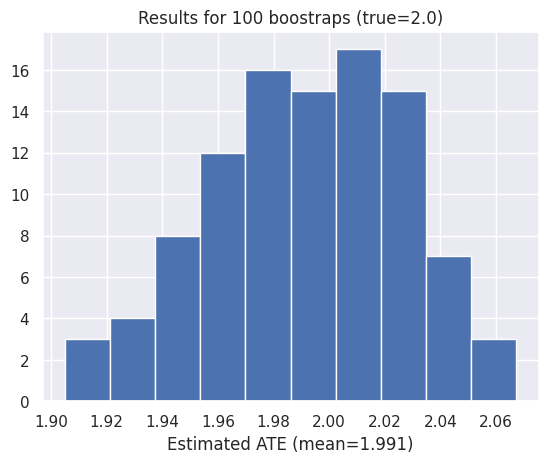

In [10]:
n_boots = 100
tau = 2.0

ATE_estimates = []
mean_res_treats = []
mean_res_contrs = []
mean_res_diffs = []

for i in tqdm(range(n_boots)):
    population = generate_population(m_func=m_func, seed=i, n_components=n_components)
    population = population.apply(add_treatment, axis=1)
    population_t1 = fit_model(population.copy(), n_components, M_col='Mt1', verbose=0)
    ATE_estimate = get_ate(population_t1, pred_Y_col='Y_hat')
    ATE_estimates.append(ATE_estimate)
    
    # Calculate residuals to check for systematic errors
    mean_res_t = population_t1.groupby('T')['Residuals'].mean()
    mean_res_treats.append(mean_res_t[0])
    mean_res_contrs.append(mean_res_t[1])
    mean_res_diffs.append(mean_res_t[0] - mean_res_t[1])

plt.hist(ATE_estimates)
plt.xlabel(f'Estimated ATE (mean={np.mean(ATE_estimates):.3f})')
plt.title(f'Results for {n_boots} boostraps (true={tau})')
plt.show()

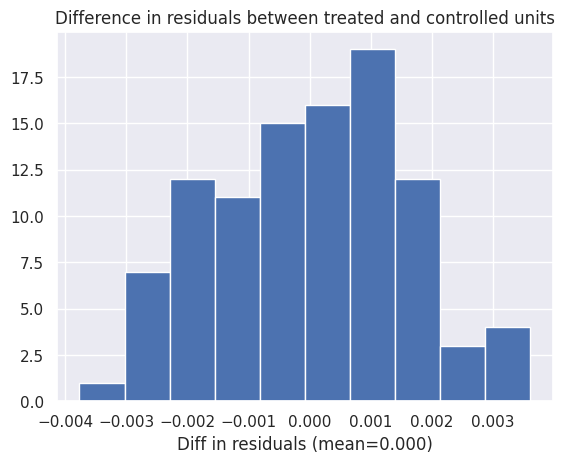

In [11]:
plt.hist(mean_res_diffs)
plt.xlabel(f'Diff in residuals (mean={np.mean(mean_res_diffs):.3f})')
plt.title('Difference in residuals between treated and controlled units')
plt.show()

## Results

In order for our method to work, we need to be careful with how we introduce the simulated treatment.

If we add the 

---

---

---